In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import Sequential
sns.set()
import numpy as np
from tensorflow.keras import layers, losses


In [2]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = df.values
df.head()


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
pd.Series(labels).value_counts()


1.0    2919
0.0    2079
dtype: int64

In [4]:
train_data,test_data, train_labels,test_labels = train_test_split(
    data, labels, test_size = 0.2, random_state=21
)



In [5]:
min = np.min(train_data)
max = np.max(train_data)
train_data = ( train_data - min ) / ( max - min )
test_data = ( test_data - min ) / ( max - min )


In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
anamalous_train_data = train_data[~train_labels]
anamalous_test_data = test_data[~test_labels]


In [ ]:
~train_labels



array([False, False, False, ..., False, False, False])

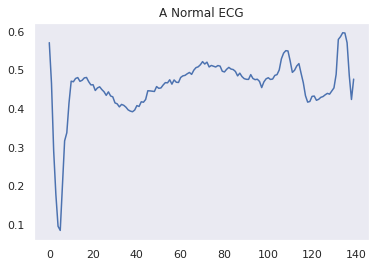

In [7]:

plt.grid()
plt.plot(np.arange(140),normal_train_data[0])
plt.title('A Normal ECG')
plt.show()


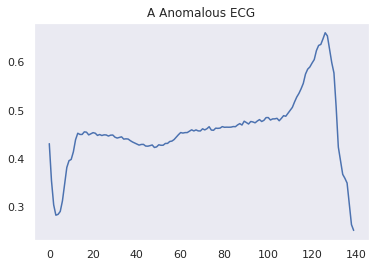

In [8]:
plt.grid()
plt.plot(np.arange(140),anamalous_train_data[0])
plt.title('A Anomalous ECG')
plt.show()


In [9]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = Sequential([
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(8, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()


In [10]:
autoencoder.compile(optimizer='adam', loss='mae')

In [11]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                         epochs = 20,
                         batch_size=512, 
                         validation_data=(normal_test_data, normal_test_data),
                         shuffle=True)


Epoch 1/20
5/5 [==============================] - 1s 49ms/step - loss: 0.0579 - val_loss: 0.0566
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0558 - val_loss: 0.0540
Epoch 3/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0529 - val_loss: 0.0505
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0491 - val_loss: 0.0463
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0448 - val_loss: 0.0419
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0405 - val_loss: 0.0379
Epoch 7/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0366 - val_loss: 0.0343
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0332 - val_loss: 0.0311
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0303 - val_loss: 0.0285
Epoch 10/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0280 - val_loss: 0.0267
Epoch 11/20
5/5 [============

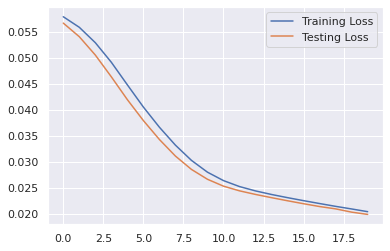

In [12]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Testing Loss')
plt.legend()


In [13]:
encoded_image = autoencoder.encoder(normal_test_data).numpy()
decoded_image = autoencoder.decoder(encoded_image).numpy()


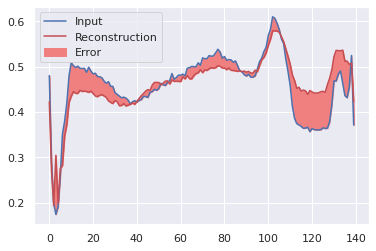

In [14]:
encoded_image = autoencoder.encoder(normal_test_data).numpy()
decoded_image = autoencoder.decoder(encoded_image).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_image[0],'r')
plt.fill_between(np.arange(140),decoded_image[0],normal_test_data[0],color='lightcoral')
plt.legend(labels=['Input',"Reconstruction","Error"])
plt.show()


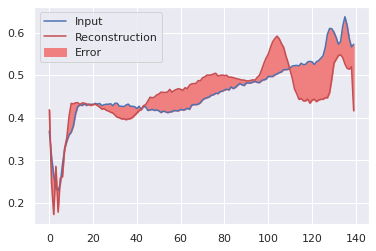

In [15]:
encoded_image = autoencoder.encoder(anamalous_test_data).numpy()
decoded_image = autoencoder.decoder(encoded_image).numpy()

plt.plot(anamalous_test_data[0],'b')
plt.plot(decoded_image[0],'r')
plt.fill_between(np.arange(140),decoded_image[0],anamalous_test_data[0],color='lightcoral')
plt.legend(labels=['Input',"Reconstruction","Error"])
plt.show()


74/74 [==============================] - 0s 1ms/step


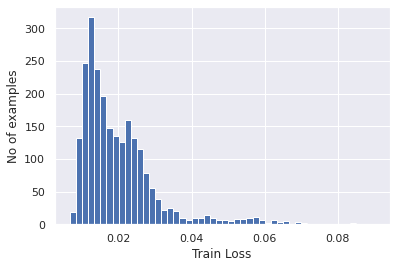

In [16]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:],bins=50)
plt.xlabel("Train Loss")
plt.ylabel("No of examples")
plt.show()


In [17]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ",threshold)


Threshold:  0.031105730162931992


14/14 [==============================] - 0s 2ms/step


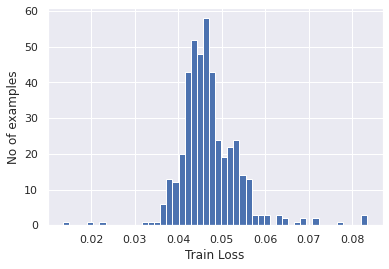

In [18]:
reconstructions = autoencoder.predict(anamalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anamalous_test_data)

plt.hist(test_loss[None,:],bins=50)
plt.xlabel("Train Loss")
plt.ylabel("No of examples")
plt.show()


In [19]:
def predict(model,data,threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions,data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels,preds)))
  print("Precision = {}".format(precision_score(labels,preds)))
  print("Recall = {}".format(recall_score(labels,preds)))
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)


Accuracy = 0.942
Precision = 0.9940944881889764
Recall = 0.9017857142857143
